<a href="https://colab.research.google.com/github/tommasomora01/StockIndexClassification/blob/main/StockIndexClassification_COLABnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/StockPrediction'
config_file_path = '/content/drive/MyDrive/StockPrediction/config.json'
folders = ['/content/drive/MyDrive/StockPrediction/models_saved', '/content/drive/MyDrive/StockPrediction/log_saved']

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score

import pandas as pd

import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
from typing import (Tuple)
import numpy as np


In [ ]:
import json
def load_config(config_path):
    try:
        with open(config_path, 'r') as f:
            config = json.load(f)
        return config
    except FileNotFoundError:
        print(f"Errore: Il file di configurazione {config_path} non è stato trovato.")
        return None
    except json.JSONDecodeError:
        print(f"Errore: Il file {config_path} contiene errori di sintassi.")
        return None

In [ ]:
dataset = pd.read_excel("/content/drive/MyDrive/StockPrediction/model_data.xlsx", sheet_name="DATA")

config = load_config(config_file_path)

dataset = dataset.set_index('Data')

cleared_dataset = dataset.dropna()


{'dataset_params': {'year_start': 2019, 'year_end': 2023, 'month_start': 0, 'month_end': 6, 'sequence_length': 90, 'offset': 1, 'distance_pred': 365}, 'model_params': {'input_size': 16, 'output_size': 3, 'dimension': 'small', 'd_model': 32, 'n_head': 4, 'dim_feedforward': 32, 'num_layers': 3, 'kernel_size': 3, 'dropout': 0.1, 'batch_size': 6, 'early_stopping_patience': 5, 'early_stopping_delta': 0.001}}


In [ ]:
print(cleared_dataset.head())
print(cleared_dataset[['SPX Index', 'VIX', 'MOVE Index']].head())


            SPX Index    VIX  MOVE Index  10Y-2Y %  OAS HY\n( vs GOV)  \
Data                                                                    
2001-01-02  1299.3655  29.99      113.93   0.00054           0.086520   
2001-01-03  1364.6333  26.60      112.96   0.00229           0.085028   
2001-01-04  1350.2664  26.97      114.51   0.00252           0.085185   
2001-01-05  1314.8405  28.67      117.05   0.00362           0.085383   
2001-01-08  1312.5920  29.84      119.37   0.00396           0.085498   

              E_EXP    OIL  US Breakeven 10 Y  Return \n1 month  \
Data                                                              
2001-01-02  54.9447  27.21             1.3159         -0.023489   
2001-01-03  54.9537  28.00             1.5127          0.018017   
2001-01-04  54.9371  28.14             1.4614         -0.030449   
2001-01-05  54.9203  27.95             1.4425         -0.038554   
2001-01-08  54.9138  27.32             1.5037         -0.034575   

            Return

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the cleared dataset
normalized_dataset = scaler.fit_transform(cleared_dataset)
# Convert the normalized dataset back to a DataFrame
normalized_df = pd.DataFrame(normalized_dataset, columns=cleared_dataset.columns, index=cleared_dataset.index)



In [ ]:
class DatasetHandler:
    def __init__(self, dataset, year_start, month_start, year_end, month_end):
        self.dataset = dataset
        self.year_start = year_start
        self.month_start = month_start
        self.year_end = year_end
        self.month_end = month_end

    def split_dataset(self):
        # Crea il dataset di addestramento in base ai parametri di inizio e fine
        train_dataset = self.dataset[
            (self.dataset.index.year == self.year_start) & (self.dataset.index.month >= self.month_start) |
            (self.dataset.index.year > self.year_start) & (self.dataset.index.year < self.year_end) |
            (self.dataset.index.year == self.year_end) &  (self.dataset.index.month <= self.month_end)
        ]

        # Crea il dataset di test che segue i dati di addestramento
        test_dataset = self.dataset[
            (self.dataset.index.year == self.year_end) & (self.dataset.index.month > self.month_end) |
            (self.dataset.index.year > self.year_end)
        ]

        return train_dataset, test_dataset


In [ ]:
# dataset_handler = DatasetHandler(normalized_df,year_start=2019,month_start=0,year_end=2023,month_end=6)
# train_model_dataset , final_test_dataset = dataset_handler.split_dataset()
#train_model_dataset = normalized_df[(normalized_df.index.year.isin([2019, 2020, 2021,2022])) | ((normalized_df.index.year == 2023) & (normalized_df.index.month <= 6))]

In [ ]:
# Classe SequenceDataset per classificazione di serie numeriche
class SequenceDataset(Dataset[Tuple[torch.Tensor, int]]):
    def __init__(self, data: pd.DataFrame, sequence_length, offset, distance_pred):
        self.data = data
        self.sequence_length = sequence_length
        self.offset = offset
        self.distance_pred = distance_pred
        self.num_up = 0
        self.num_down = 0
        self.num_neutral = 0
        self.classification_params = {
        30: {"sup": 0.5, "inf": -0.1},
        90: {"sup": 10, "inf": -0.1},
        365: {"sup": 35, "inf": 0}
        }
        self.inputs, self.targets = self._create_sequences_and_labels()


    def _create_sequences_and_labels(self):
        inputs = []
        targets = []
        sps = self.data['SPX Index'].values
        self.num_up = 0
        self.num_down = 0
        self.num_neutral = 0

        for end_index in range(self.sequence_length, len(sps)-self.distance_pred, self.offset):
            sequence = self.data.iloc[end_index - self.sequence_length :end_index ].values
            last_value = sps[end_index-1]
            future_value = sps[end_index -1 + self.distance_pred]

            # Calcola la variazione percentuale
            perc_change = (future_value - last_value) / last_value * 100

            # Assegna la classe in base alla variazione percentuale
            if perc_change > self.classification_params[self.distance_pred]["sup"]:
                label = 2  # Classe UP
                self.num_up +=1
            elif perc_change < self.classification_params[self.distance_pred]["inf"]:
                label = 0  # Classe DOWN
                self.num_down +=1
            else:
                label = 1  # Classe NEUTRAL
                self.num_neutral +=1

            inputs.append(sequence)
            targets.append(label)
        total = self.num_down + self.num_neutral + self.num_up
        total = total if total != 0 else 1
        perc_down = (self.num_down / total) * 100
        perc_neutral = (self.num_neutral / total) * 100
        perc_up = (self.num_up / total) * 100
        print(f"Num DOWN = {self.num_down}, {perc_down}% (inf = {self.classification_params[self.distance_pred]['inf']}) ;"
              f"Num NEUTRAL = {self.num_neutral}, {perc_neutral}%  ;"
              f" Num UP = {self.num_up}, {perc_up}% (sup = {self.classification_params[self.distance_pred]['sup']})")

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def show_sequence(self,plot_mode=False, max_num=None):
        perc_changes = []

        if max_num is None or max_num > len(self):
            max_num = len(self)
        for i in range(max_num):
            start_index = i * self.offset
            start_date = self.data.index[start_index]
            end_date = self.data.index[start_index + self.sequence_length - 1]
            pred_date = self.data.index[start_index + self.sequence_length - 1 + self.distance_pred]
            start_value = self.data.iloc[start_index]["SPX Index"]
            end_value = self.data.iloc[start_index + self.sequence_length - 1]["SPX Index"]
            pred_value = self.data.iloc[start_index + self.sequence_length - 1 + self.distance_pred]["SPX Index"]
            _, label = self[i]
            perc_change = (pred_value - end_value) / end_value * 100
            perc_changes.append(perc_change)

            if(not plot_mode):
                print(f"Data inizio-sequenza: {start_date}, Valore inizio: {start_value}")
                print(f"Data fine-sequenza: {end_date}, Valore fine: {end_value}")
                print(f"Data previsione: {pred_date}, Valore previsione: {pred_value}")
                print(f"Variazione percentuale: {perc_change}%")
                print(f"Classe: {'UP' if label == 2 else 'NEUTRAL' if label == 1 else 'DOWN'}\n")
        if plot_mode:
            # Definisci i bins per l'istogramma
            bins = list(range(-100, 101, 5))
            frequencies, edges = np.histogram(perc_changes, bins=bins)
            # Crea l'istogramma
            plt.figure(figsize=(10, 5))
            plt.hist(perc_changes, bins=bins, edgecolor='black', alpha=0.7, width=5)
            plt.title('Istogramma delle Variazioni Percentuali')
            plt.xlabel('Variazione Percentuale (%)')
            plt.ylabel('Frequenza')
            plt.grid(axis='y', alpha=0.75)

            # Personalizza i tick dell'asse x
            xticks = list(range(-100, 101, 5))
            plt.xticks(xticks,rotation=90)
            plt.xlim([-100, 100])  # Imposta i limiti dell'asse x
            for i in range(len(frequencies)):
                plt.text(edges[i] + (edges[i + 1] - edges[i]) / 2, frequencies[i], str(frequencies[i]),
                 ha='center', va='bottom')
            plt.tight_layout()
            plt.show()

In [ ]:
# train_inputs = normalized_df.iloc[:,:]
# train_inputs = train_model_dataset.iloc[:,:]
# folders[0] = os.path.join(folders[0],"dataset_2019_2022")
# folders[1] = os.path.join(folders[1],"dataset_2019_2022")
# print(type(train_inputs))
# print(train_inputs.shape)


# X_train_tensor = torch.tensor(train_inputs.to_numpy())

# print(type(X_train_tensor))
# print(X_train_tensor.shape)



<class 'pandas.core.frame.DataFrame'>
(1174, 14)
<class 'torch.Tensor'>
torch.Size([1174, 14])


In [ ]:

# Definizione del modello
class TimeSeriesModel(nn.Module):
    def __init__(self,
                 input_size,
                 output_size,
                 dimension,
                 d_model=32,
                 n_head=8,
                 dim_feedforward=256,
                 num_layers=6,
                 batch_first=False,
                 enable_nested_tensor=True,
                 kernel_size=5,
                 dropout=0.1):
        super(TimeSeriesModel, self).__init__()

        self.dimension = dimension
        self.input_size = input_size
        self.output_size = output_size
        self.d_model = d_model

        if(self.dimension == "medium"):
            self.conv1 = nn.Conv1d(input_size, d_model, kernel_size=kernel_size, padding='same', padding_mode="reflect")
            self.relu1 = nn.ReLU()
            #self.transformer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, dim_feedforward=dim_feedforward, batch_first = batch_first)
            self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, dim_feedforward=dim_feedforward, batch_first = batch_first), num_layers=num_layers, enable_nested_tensor=enable_nested_tensor)
            self.relu2 = nn.ReLU()
            self.conv2 = nn.Conv1d(d_model, d_model//2, kernel_size=3)
            self.relu3 = nn.ReLU()
            self.classification_layer = nn.Linear(d_model//2, output_size)
            #self.softmax = nn.Softmax(dim=1)
        else:
            self.conv1 = nn.Conv1d(input_size, d_model, kernel_size=kernel_size, padding='same', padding_mode="reflect")
            self.relu1 = nn.ReLU()
            self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, dim_feedforward=dim_feedforward, batch_first = batch_first), num_layers=num_layers, enable_nested_tensor=enable_nested_tensor)
            self.relu2 = nn.ReLU()
            self.classification_layer = nn.Linear(d_model, output_size)


    def forward(self, x):
        if(self.dimension == "medium"):
            x = x.permute(0,2,1)
            x = self.conv1(x)
            #print("After conv1:", x.shape)
            x = self.relu1(x)
            x = x.permute(0, 2, 1)  # Permuta per il Transformer
            x = self.transformer(x)
            #print("After transformer:", x.shape)
            x = x.permute(0, 2, 1)  # Riporta alla forma della conv1
            x = self.relu2(x)
            x = self.conv2(x)
            #print("After conv2:", x.shape)
            x = self.relu3(x)
            x = torch.mean(x, dim=2)  # Pooling globale sulla dimensione della sequenza
            x = self.classification_layer(x)
            #print("After classification:", x.shape)
            #x = self.softmax(x)
        else:
            x = x.permute(0,2,1)
            x = self.conv1(x)
            x = self.relu1(x)
            x = x.permute(0, 2, 1)
            x = self.transformer(x)
            x = x.permute(0, 2, 1)
            x = self.relu2(x)
            x = torch.mean(x, dim=2)
            x = self.classification_layer(x)
        return x



In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.delta = delta

    def __call__(self,loss) :
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss > self.delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [ ]:
# Funzione di training
def train_model(model, train_loader, val_loader, criterion, optimizer, device,early_stopping = None):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        #print("inputs[0].shape",inputs[0].shape)
        #print("inputs[1].shape",targets[1].shape)
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print("outputs.shape",outputs.shape)
        #print("targets.shape",targets.shape)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    if early_stopping:
        if(early_stopping(avg_val_loss)):
            print(f"Early stopping triggered")
            return avg_train_loss,True
    return avg_train_loss,False

# Funzione di valutazione
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
        print(f"all_predictions = \n{all_predictions}")
        print(f"all_targets = \n{all_targets}")
    accuracy = accuracy_score(all_targets, all_predictions)
    return accuracy, all_predictions, all_targets



In [ ]:
# Iperparametri
# sequence_length = 90
# offset = 1
# distance_pred = 365
# output_size = 3  # Numero di classi: D, N, U
# learning_rate = 0.0001
# num_epochs = 1000
# batch_size = 12
# folders[0] = os.path.join(folders[0],f"{distance_pred}gg")
# folders[1] = os.path.join(folders[1],f"{distance_pred}gg")


In [ ]:
print(folders[0])
print(folders[1])

/content/drive/MyDrive/StockPrediction/models_saved/dataset_2019_2022/30gg
/content/drive/MyDrive/StockPrediction/log_saved/dataset_2019_2022/30gg


Num DOWN = 220, 30.598052851182196% (sup = 30) ;Num NEUTRAL = 123, 17.10709318497914%  ; Num UP = 376, 52.29485396383866% (inf = 0)


<ipython-input-13-e3d85c3f45fe>:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)


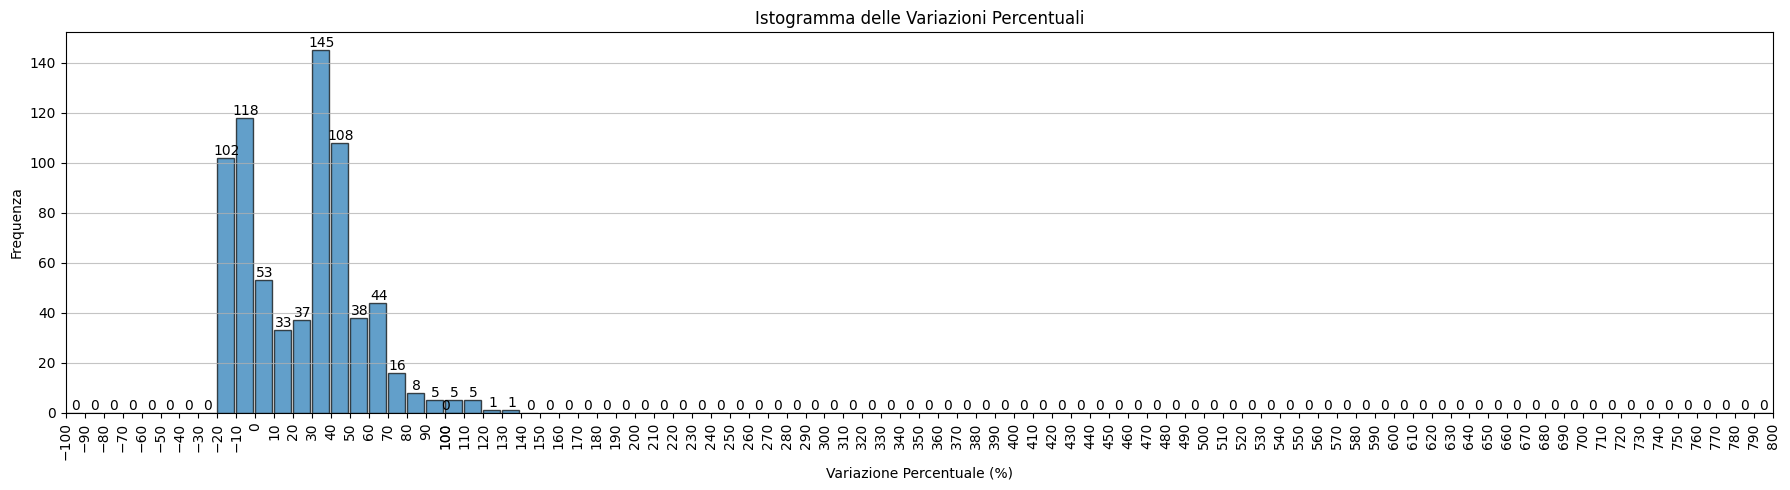

torch.Size([12, 90, 14])
torch.Size([12])
torch.Size([12, 90, 14])
torch.Size([12])


In [ ]:
# # Creazione del dataset
# dataset = SequenceDataset(train_inputs, sequence_length=sequence_length, offset=offset,distance_pred=distance_pred)
# dataset.show_sequence(plot_mode=True)
# # Split train-test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # Creazione dei DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# for inputs in train_loader:
#   print(inputs[0].shape)
#   print(inputs[1].shape)
#   break

# for inputs in test_loader:
#     print(inputs[0].shape)
#     print(inputs[1].shape)
#     break


In [ ]:
# import uuid
# from itertools import product
# from tqdm.notebook import tqdm

# list_dmodel = [16,32]#,64, 128]
# list_head = [2, 4]#,8]
# list_layers = [2, 3]#,6]
# list_ff_dim = [16,32]#,64, 256]
# list_offset = [1, 2]#, 3, 4]
# list_batches = [6,8]#,10]
# kernel_size = [1,3]#, 5]
# dimensions = ["small"]#, "medium"]
# num_epochs = 1000

# # Definizione del dataframe per il log dei risultati
# result_dataframe_log = pd.DataFrame()

# # Generazione delle combinazioni dei parametri
# option_clusterlist = list(product(list_batches, list_offset, list_dmodel, list_head, list_ff_dim, list_layers, kernel_size,dimensions))

# # Filtraggio delle combinazioni valide
# option_cleared = []
# for batch_n, offset, d_model, n_head, ff_dim, num_layer, kernel, dimension in option_clusterlist:
#     if ff_dim >= d_model:
#         option_cleared.append((batch_n, offset, d_model, n_head, ff_dim, num_layer, kernel, dimension))

# # Loop su ogni configurazione valida
# for batch_n, offset, d_model, n_head, ff_dim, num_layer, kernel, dimension in tqdm(option_cleared, desc="Creazione e addestramento modelli"):
#     model_id = str(uuid.uuid4())
#     model = TimeSeriesModel(
#         input_size=train_inputs.shape[-1],
#         output_size=3,
#         dimension=dimension,
#         d_model=d_model,
#         n_head=n_head,
#         dim_feedforward=ff_dim,
#         num_layers=num_layer,
#         kernel_size=kernel,
#         dropout=0.1
#     )

#     # Impostiamo ottimizzatore e funzione di perdita
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.CrossEntropyLoss()  # Modifica in base alla tua funzione di perdita
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     for m in model.modules():
#         if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
#             nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ReLU activation
#         if isinstance(m, (nn.TransformerEncoderLayer)):
#             nn.init.xavier_uniform_(m.linear1.weight)
#             nn.init.xavier_uniform_(m.linear2.weight)
#     # File di log dei risultati
#     log_file = f"training_log_{model_id}.txt"
#     model_file = f"model_{model_id}.pt"
#     early_stopping = EarlyStopping(delta=0.001)
#     with open(os.path.join(folders[1],log_file), "w") as f:
#         for epoch in range(num_epochs):

#             train_loss, stop = train_model(model, train_loader, test_loader, criterion, optimizer, device, early_stopping)
#             f.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}\n")
#             print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

#             if stop:  # Early stopping, valutazione finale
#                 test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
#                 f.write(f"Early stopping triggered.\n")
#                 f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
#                 f.write(f"all_predictions = \n{all_predictions}\n")
#                 f.write(f"all_targets = \n{all_targets}\n")
#                 break

#         # Test finale, se l'early stopping non è stato attivato
#         if not stop:
#             test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
#             f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
#             f.write(f"all_predictions = \n{all_predictions}\n")
#             f.write(f"all_targets = \n{all_targets}\n")

#     # Salvataggio del modello
#     torch.save(model.state_dict(), os.path.join(folders[0],model_file))
#     print(f"Modello salvato in {model_file}")

#     # Aggiungiamo i dettagli al log generale
#     result_dataframe_log = pd.concat([result_dataframe_log,pd.DataFrame([{
#         "Model_ID": model_id,
#         "Batch_Size": batch_n,
#         "Feature_length": train_inputs.shape[-1],
#         "Offset": offset,
#         "D_Model": d_model,
#         "N_Head": n_head,
#         "FF_Dim": ff_dim,
#         "Num_Layers": num_layer,
#         "Kernel_Size": kernel,
#         "Model_File": model_file,
#         "Log_File": log_file,
#         "Sequence Length" : sequence_length,
#         "Start Year Dataset": dataset_handler.year_start,
#         "Start Month Dataset": dataset_handler.month_start,
#         "End Year Dataset": dataset_handler.year_end,
#         "End Month Dataset": dataset_handler.month_end,
#         "Test_Accuracy": test_accuracy
#     }])], ignore_index=True)

# # Salvataggio del dataframe come CSV
# log_model_path = os.path.join(base_path, f"log_modelli_{dimension}Model_datasetSmall_{distance_pred}gg.csv")
# file_exist = os.path.isfile(log_model_path)
# result_dataframe_log = result_dataframe_log.sort_values(by="Test_Accuracy", ascending=False)
# result_dataframe_log.to_csv(log_model_path, mode = "a",header = not file_exist, index=False)
# print(f"Log generale salvato in log_modelli_{dimension}Model_datasetSmall_{distance_pred}gg.csv")

Creazione e addestramento modelli:   0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/1000], Loss: 0.9892
Epoch [2/1000], Loss: 0.7267


KeyboardInterrupt: 

In [ ]:
# Creazione del modello
# model = TimeSeriesModel(train_inputs.shape[-1], output_size,"small",d_model = 16, n_head= 4, dim_feedforward= 64, num_layers=2, kernel_size=3)

# for m in model.modules():
#     if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ReLU activation
#     if isinstance(m, (nn.TransformerEncoderLayer)):
#         nn.init.xavier_uniform_(m.linear1.weight)
#         nn.init.xavier_uniform_(m.linear2.weight)

# print(f"train_inputs.shape[-1] =  {train_inputs.shape[-1]}")
# print(f"output_size =  {output_size}")

# #print("\n MODELLO \n")

# print(model)




In [ ]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# #summary(model, (train_inputs.shape[-1], output_size), device)
# #class_counts = torch.tensor([train_dataset.num_down, train_dataset.num_neutral, train_dataset.num_up], dtype=torch.float)
# class_counts = torch.tensor([dataset.num_down, dataset.num_neutral, dataset.num_up], dtype=torch.float)
# class_weights = 1.0 / class_counts
# class_weights = class_weights / class_weights.sum()


# # Definizione della loss e dell'optimizer
# criterion = nn.CrossEntropyLoss()#weight=class_weights.to(device))
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [ ]:
#early_stopping = EarlyStopping(delta=0.001)

In [ ]:
# Training del modello
# for epoch in range(num_epochs):
#     train_loss,stop = train_model(model, train_loader, test_loader, criterion, optimizer, device,early_stopping)
#     #val_loss = evaluate_model(model, test_loader, device

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
#     if stop:
#         break


In [ ]:
# Valutazione del modello sul test set
# test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
# #test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
# print(f"Accuracy sul test set: {test_accuracy:.4f}")


In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns


# # Calcolare la matrice di confusione
# cm = confusion_matrix(all_targets, all_predictions)

# # Visualizzare la matrice di confusione
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Neutral', 'Up','Very_Up'], yticklabels=['Down', 'Neutral', 'Up','Very_Up'])
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.title('Confusion Matrix')
# plt.show()

# # Stampa la matrice di confusione
# print("Matrice di Confusione:")
# print(cm)

In [ ]:
#!pip install -r /content/drive/MyDrive/StockPrediction/requirements.txt

In [ ]:
# dev = torch.device("cpu")

# if torch.cuda.is_available():
#     print(f"GPU {torch.cuda.get_device_name(0)} is available")
#     dev = torch.device("cuda")

# torch.set_default_device(dev)
# torch.set_default_dtype(torch.float64)

# print(dev.type)

In [ ]:
# def set_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     np.random.seed(seed)
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

# # Fissa il seed
# set_seed(42)

In [ ]:
# import os
# import shutil

# # Cartelle di Drive da vuotare o creare
# folders = ['/content/drive/MyDrive/StockPrediction/models_saved', '/content/drive/MyDrive/StockPrediction/plot_saved']

# for folder_path in folders:
# # Controlla se la cartella esiste
#     if os.path.exists(folder_path):
#         # Elimina il contenuto della cartella
#         shutil.rmtree(folder_path)
#         # Ricrea la cartella vuota se necessario
#         os.makedirs(folder_path)
#     else:
#         print(f"La cartella {folder_path} non esiste, la creo.")
#         os.makedirs(folder_path)


In [ ]:
# class SequenceDataset(Dataset[Tuple[Tensor, ...]]):
#     def __init__(self, inputs: Tensor, targets: Tensor, sequence_length: int = 1, offset: int = None):
#         assert inputs.size(0) == targets.size(0), "Size mismatch between tensors"
#         assert  (offset == None) or (offset > 0), "Offset non può essere negativo"
#         inputs = inputs[:-sequence_length]
#         targets = targets[sequence_length:]
#         self.inputs = []
#         self.targets = []
#         end_array = len(inputs)

#         for start_index in range(0, end_array, offset if offset is not None else sequence_length):
#             end_index = start_index + sequence_length
#             if end_index > end_array:
#                 break
#             else:
#                 self.inputs.append(torch.stack([inputs[j] for j in range(start_index, end_index)]))
#                 self.targets.append(torch.stack([targets[k] for k in range(start_index, end_index)]))

#     def __len__(self):
#         return len(self.inputs)

#     def __getitem__(self, index):
#         return self.inputs[index], self.targets[index]

In [ ]:
# dataset = pd.read_excel("/content/drive/MyDrive/StockPrediction/model_data.xlsx", sheet_name="DATA")

# dataset = dataset.set_index('Data')

# cleared_dataset = dataset.dropna()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Normalize the cleared dataset
# normalized_dataset = scaler.fit_transform(cleared_dataset)
# # Convert the normalized dataset back to a DataFrame
# normalized_df = pd.DataFrame(normalized_dataset, columns=cleared_dataset.columns, index=cleared_dataset.index)

# scaler_index = MinMaxScaler()
# normalized_spxindex_dataset = scaler_index.fit_transform(cleared_dataset[['SPX Index']])

# train_model_dataset = normalized_df[(normalized_df.index.year.isin([2019, 2020, 2021])) | ((normalized_df.index.year == 2022) & (normalized_df.index.month <= 6))]

# real_world_dataset = normalized_df[((normalized_df.index.year == 2022) & (normalized_df.index.month > 6))| (normalized_df.index.year.isin([2023, 2024])) ]



In [ ]:
# # train_inputs = train_model_dataset
# train_inputs = train_model_dataset.iloc[:,:]
# train_targets = train_model_dataset[['SPX Index']]

# # realworl_inputs = real_world_dataset
# realworl_inputs = real_world_dataset.iloc[:,:]
# realworld_targets = real_world_dataset[['SPX Index']]

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(train_inputs, train_targets, test_size=0.3, shuffle=False)

# X_train_tensor = torch.tensor(X_train.to_numpy())

# y_train_tensor = torch.tensor(y_train.to_numpy())

# X_test_tensor = torch.tensor(X_test.to_numpy())

# y_test_tensor = torch.tensor(y_test.to_numpy())



In [ ]:
# train_sequence = SequenceDataset(X_train_tensor, y_train_tensor, sequence_length=10, offset=5)

# test_sequence = SequenceDataset(X_test_tensor, y_test_tensor, sequence_length=10,  offset=5)

# train_dataloader = DataLoader(train_sequence, batch_size=10, generator=torch.Generator(device='cuda'), shuffle=False)

# val_dataloader = DataLoader(test_sequence,  batch_size=10, generator=torch.Generator(device='cuda'), shuffle=False)



In [ ]:
# def print_batches(dataloader, batch_indices):
#     for batch_idx, (x_batch, y_batch) in enumerate(train_dataloader):
#         if batch_idx in batch_indices:
#             print(f"Batch {batch_idx + 1}:")
#             print("X_batch:", x_batch)
#             print("Y_batch:", y_batch)
#             print()  # Linea vuota per separare i batch
#         if batch_idx >= max(batch_indices):
#             break

# # Stampa il primo batch
# print_batches(train_dataloader, [0])

In [ ]:
# class StockIndexTransformer(Module):
#     def __init__(self,
#                  input_size: int,
#                  output_size: int,
#                  d_model: int,
#                  n_head: int = 8,
#                  dim_feedforward: int = 2048,
#                  num_layers: int = 6,
#                  batch_first: bool = False,
#                  enable_nested_tensor: bool = True,
#                  kernel_size: int = 1) -> None:
#         super(StockIndexTransformer, self).__init__()

#         self.input_size = input_size
#         self.output_size = output_size
#         self.d_model = d_model

#         self.linearInput = Conv1d(input_size, d_model, kernel_size=kernel_size, padding='same', padding_mode="reflect")

#         self.transformer = TransformerEncoder(TransformerEncoderLayer(d_model=d_model, nhead=n_head, dim_feedforward=dim_feedforward, batch_first = batch_first), num_layers=num_layers, enable_nested_tensor=enable_nested_tensor)

#         self.linearOutput = Conv1d(d_model, output_size, kernel_size=kernel_size, padding='same', padding_mode="reflect")

#     def forward(self, src): # src: (batch, sequence, features)

#         src = src.permute(0,2,1)

#         src = self.linearInput(src)

#         src = src.permute(0,2,1)

#         # src =src.permute(1, 0, 2) # sequence, batches, features

#         src = self.transformer(src)

#         # src = src.permute(1, 0, 2) # batches, features, sequence

#         src = src.permute(0,2,1)
#         src =  self.linearOutput(src)
#         src = src.permute(0,2,1)

#         return src

In [ ]:
#model = StockIndexTransformer(train_inputs.shape[-1], train_targets.shape[-1], d_model=128, n_head = 2, dim_feedforward= 256, num_layers = 1, batch_first = True, enable_nested_tensor = True, kernel_size=5)

In [ ]:
# def train(verbose: bool = False, uuid= None):
#     global train_dataloader
#     global val_dataloader
#     global model

#     train_dataframe_log = pd.DataFrame()

#     criterion = MSELoss()
#     optimizer = Adam(model.parameters(), lr=0.001)


#     train_losses = []
#     val_losses = []
#     mse_values = []
#     mae_values = []
#     mape_values = []
#     early_stop_counter = 0


#     # Training loop
#     num_epochs = 9000
#     patience = 10  # Number of epochs to wait for improvement
#     best_val_loss = float('inf')
#     for epoch in range(num_epochs):
#         # Training

#         model.train()


#         for inputs, target in train_dataloader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, target)
#             loss.backward()
#             optimizer.step()


#         # Validation
#         model.eval()
#         val_loss = 0.0
#         total_mse = 0.0
#         total_mae = 0.0
#         total_mape = 0.0
#         total_samples = 0

#         # with torch.no_grad():
#         for inputs, target in val_dataloader:
#             outputs = model(inputs)
#             val_loss += criterion(outputs, target).item()

#             mse = mse_loss(outputs, target).item()
#             mae = L1Loss()(outputs, target).item()
#             mape = torch.mean(torch.abs((target - outputs) / target)).item() * 100

#             total_mse += mse
#             total_mae += mae
#             total_mape += mape
#             total_samples += len(target)

#         try:
#             val_loss /= len(val_dataloader)
#         except ZeroDivisionError as e:
#             val_loss = float('inf')

#         try:
#             mse_avg = total_mse / total_samples
#         except ZeroDivisionError as e:
#             mse_avg = float('inf')

#         try:
#             mae_avg = total_mae / total_samples
#         except ZeroDivisionError as e:
#             mae_avg = float('inf')

#         try:
#             mape_avg = total_mape / total_samples
#         except ZeroDivisionError as e:
#             mape_avg = float('inf')

#         # mse_avg = total_mse / total_samples
#         # mae_avg = total_mae / total_samples
#         # mape_avg = total_mape / total_samples

#         val_losses.append(val_loss)
#         mse_values.append(mse_avg)
#         mae_values.append(mae_avg)
#         mape_values.append(mape_avg)

#         if train_dataframe_log.empty:
#             # train_dataframe_log = pd.DataFrame({"Percentage of Loss": (val_loss / sum(val_losses) * 100), "Validation Loss": val_loss, "MSE": mse_avg, "MAE": mae_avg, "MAPE": mape_avg})
#             data = {"Percentage of Loss": [(val_loss / sum(val_losses) * 100)], "Validation Loss": [val_loss], "MSE": [mse_avg], "MAE": [mae_avg], "MAPE": [mape_avg]}
#             train_dataframe_log = pd.DataFrame(data)
#         else:
#             # train_dataframe_log = pd.concat([train_dataframe_log, pd.DataFrame({"Percentage of Loss": (val_loss / sum(val_losses) * 100), "Validation Loss": val_loss, "MSE": mse_avg, "MAE": mae_avg, "MAPE": mape_avg})])
#             data = {"Percentage of Loss": [(val_loss / sum(val_losses) * 100)], "Validation Loss": [val_loss], "MSE": [mse_avg], "MAE": [mae_avg], "MAPE": [mape_avg]}
#             train_dataframe_log = pd.concat([train_dataframe_log, pd.DataFrame(data)], ignore_index=True)
#         # Print losses, MSE, MAE, and MAPE
#         if verbose:
#             print(f'Epoch {epoch + 1:02d}:{num_epochs} Percentage of Loss: {val_loss / sum(val_losses) * 100:.2f}% Validation Loss: {val_loss:.4f}, MSE: {mse_avg:.4f}, MAE: {mae_avg:.4f}, MAPE: {mape_avg:.4f}%')

#         if epoch == 0:
#             torch.save(model.state_dict(), '/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model.pth' if uuid is None else f'/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model_{uuid}.pth')

#         # Check for early stopping and save the best model
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             early_stop_counter = 0
#             # Save the model
#             torch.save(model.state_dict(), '/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model.pth' if uuid is None else f'/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model_{uuid}.pth')
#         else:
#             early_stop_counter += 1
#             if early_stop_counter >= patience:
#                 if verbose:
#                     print(f'Early stopping at epoch {epoch+1}!')
#                 break
#     model.load_state_dict(torch.load('/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model.pth' if uuid is None else f'/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model_{uuid}.pth'))
#     return train_dataframe_log, '/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model.pth' if uuid is None else f'/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model_{uuid}.pth'

In [ ]:
# _, _ = train(True)

In [ ]:
# if not "model" in locals():
#     model.load_state_dict(torch.load('/content/drive/MyDrive/StockPrediction/models_saved/stock_index_model.pth'))

# X_real = real_world_dataset.iloc[:,:]
# y_real = real_world_dataset[['SPX Index']]

# X_real_tensor = torch.tensor(X_real.to_numpy())

# y_real_tensor = torch.tensor(y_real.to_numpy())

# real_dataset = SequenceDataset(X_real_tensor, y_real_tensor, sequence_length=10)

# real_dataloader = DataLoader(real_dataset, generator=torch.Generator(device='cuda'))

# stock_prediction = torch.empty(0)


# stock_actual = torch.empty(0)



In [ ]:
# def test():
#     global stock_prediction
#     global stock_actual
#     global model
#     stock_prediction = torch.empty(0)
#     stock_actual = torch.empty(0)
#     with torch.no_grad():
#         model.eval()
#         for inputs, targets in real_dataloader:
#             prediction = model(inputs)
#             stock_prediction = torch.cat((stock_prediction, prediction), dim=0)
#             stock_actual = torch.cat((stock_actual, targets), dim=0)
#     stock_prediction= stock_prediction.cpu().numpy()
#     stock_actual= stock_actual.cpu().numpy()



In [ ]:
# test()

In [ ]:
# def plot(title="Stock Index Prediction", uuid : str = None, save: bool =False) -> str|None:
#     global stock_actual
#     global stock_prediction
#     figure = plt.figure(figsize=(16,9))
#     plt.plot(y_real[-stock_actual.reshape(-1).shape[0]:].index, stock_actual, label="actual")
#     plt.plot(y_real[-stock_actual.reshape(-1).shape[0]:].index, stock_prediction, label="prediction")

#     plt.xlabel("Time")
#     plt.ylabel("SPX Index")
#     plt.legend(loc="upper left")
#     plt.title(title)
#     plt.grid(True)

#     if save:
#         save_path = str(f'/content/drive/MyDrive/StockPrediction/plot_saved/Plot-{uuid}.png')
#         plt.savefig(save_path)
#         plt.close(figure)

#         return save_path
#     else:
#         plt.show()

In [ ]:
# stock_actual = scaler_index.inverse_transform(pd.DataFrame(stock_actual.reshape(-1, 1)))
# stock_prediction = scaler_index.inverse_transform(pd.DataFrame(stock_prediction.reshape(-1, 1)))
# plot(save=True)

In [ ]:
# #list_dmodel = [56, 64, 128, 256]
# #list_head = [1, 2, 4, 8]
# #list_layers = [1, 2, 3]
# #list_ff_dim = [56, 64, 128, 256, 512, 1024, 2048]

# list_dmodel = [64, 128]
# list_head = [2, 4]
# list_layers = [2, 3]
# list_ff_dim = [64, 256, 1024]

# list_sequence = [(7, 4), (7, None), (10,4), (10,None)]
# list_batches = [10]
# kernel_size = [1, 5]


# from itertools import product
# import uuid
# from tqdm.notebook import trange, tqdm

# result_dataframe_log = pd.DataFrame()

# option_clusterlist = list(product(list_batches, list_sequence, list_dmodel, list_head,  list_ff_dim, list_layers, kernel_size))

# option_cleared = []
# for batch_n, (seq, offset), d_model, n_head, ff_dim, num_layer, kernel in option_clusterlist:
#     if ff_dim >= d_model:
#         option_cleared.append((batch_n, seq, offset, d_model, n_head, ff_dim, num_layer, kernel))

# for i in trange(len(option_cleared), desc='Testing Transformer Options'):

#     batch_n, seq, offset, d_model, n_head, ff_dim, num_layer, kernel = option_cleared[i]

#     myuuid = str(uuid.uuid4())

#     train_sequence = SequenceDataset(X_train_tensor, y_train_tensor, sequence_length=seq, offset=offset)
#     test_sequence = SequenceDataset(X_test_tensor, y_test_tensor, sequence_length=seq, offset=offset)

#     train_dataloader = DataLoader(train_sequence, batch_size=batch_n, shuffle=False, generator=torch.Generator(device='cuda'))
#     val_dataloader = DataLoader(test_sequence, batch_size=batch_n, shuffle=False, generator=torch.Generator(device='cuda'))

#     model = StockIndexTransformer(train_inputs.shape[-1], train_targets.shape[-1], d_model=d_model, n_head=n_head, num_layers=num_layer, dim_feedforward=ff_dim, enable_nested_tensor=False, kernel_size=kernel)

#     df, model_path = train(uuid = myuuid)

#     real_dataset = SequenceDataset(X_real_tensor, y_real_tensor, sequence_length=seq)
#     real_dataloader = DataLoader(real_dataset,  batch_size=batch_n, generator=torch.Generator(device='cuda'))

#     test()

#     if stock_actual.size == 0:
#         continue

#     stock_actual = scaler_index.inverse_transform(pd.DataFrame(stock_actual.reshape(-1, 1), columns=['SPX Index']))
#     stock_prediction = scaler_index.inverse_transform(pd.DataFrame(stock_prediction.reshape(-1, 1), columns=['SPX Index']))

#     squared_differences = np.square(np.subtract(stock_actual, stock_prediction))
#     mean_squared_error = np.mean(squared_differences)
#     rmse = np.sqrt(mean_squared_error)

#     plot_path = plot(f"{myuuid} with d_model={d_model}, n_head={n_head}, ff_dim={ff_dim}, num_layers={num_layer}, kernel_size={kernel}" ,myuuid, True )

#     data_frame = pd.DataFrame({'ID': [myuuid], "RMSE": [rmse], "ModelPlot": [plot_path], "ModelTrain":[model_path]})
#     training_df = pd.DataFrame({'d_model':[d_model], 'n_head':[n_head], 'ff_dim':[ff_dim], 'kernel_size': [kernel], 'num_layers':[num_layer], 'batch_n':[batch_n], 'sequence_s':[seq], 'offset':[offset if offset is not None else 0]})

#     toexcell = data_frame.join(training_df, how='cross').join(df, how='cross')

#     try:
#         result_dataframe_log = pd.read_excel("TrainingData.xlsx", sheet_name="Data")
#         result_dataframe_log = pd.concat([result_dataframe_log, toexcell])
#     except FileNotFoundError:
#         result_dataframe_log = toexcell

#     try:
#         writer = pd.ExcelWriter("TrainingData.xlsx", engine="openpyxl", mode='a', if_sheet_exists='overlay')
#     except FileNotFoundError:
#         writer = pd.ExcelWriter("TrainingData.xlsx",  engine="openpyxl",  mode='x')
#     finally:
#         result_dataframe_log.to_excel(writer, sheet_name="Data", index=False)
#         writer.close()
